# NLP

### Maël Mandard - Ewen Le Cunff

In [22]:
import json
import pandas as pd
import re
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [35]:
liste = ['formation0', 'formation1', 'formation2', 'formation3', 'formation4',
         'rupture0', 'rupture1', 'rupture2', 'rupture3', 'rupture4']

date = []
texte = []
theme = []

for obj in liste :
    #f = open(f"C:/Users/Mael/Documents/Fac/M2/NLP/M2_NLP_Mandard_LeCunff/Data/{obj}.json", encoding= 'UTF-8')
    f = open(f"C:/Users/ewen/Documents/M2/NLP/M2_NLP_Mandard_LeCunff/Data/{obj}.json", encoding= 'UTF-8')
    
    data = json.load(f)
    
    them = data['query']['theme']
    
    results = data['results']
    
    for res in results : 
        theme.append(them[0])
        date.append(res['decision_date'])
        texte.append(res['text'])
    

fin_data = pd.DataFrame({'date' : date, 'theme' : theme, 'texte' : texte})

In [36]:
#1ere etape : mettre en minuscule
#2eme etape : enlever et tokenisation
#3eme etape : stop words
#4eme etape : lemmatisation

def mise_en_minuscule(text):
    return text.replace(text, text.lower())

def remove_accents(text) : 
    return unidecode(text)

def clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text) #supprimer les caractères non alphanumériques
    text = re.sub(r'\b\d+\b', '', text) #supprimer les mots qui contiennent un chiffre
    text = re.sub(r'\bxx+\b|\bXX+\b', '', text) #supprimer les mots qui contiennent une chaîne de "xx" ou "XX"
    return text

def supprime_stopwords(text):
    words = re.split(r"[ ]", text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def supprime_espace(text):
    words = re.split(r"[ ]", text)
    filtered_words = [word for word in words if word]
    return ' '.join(filtered_words)

def lemmatize(allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    fin_data['texte'] = fin_data['texte'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if token.pos_ in allowed_postags]))
    return fin_data['texte']


In [37]:
fin_data['texte'] = fin_data['texte'].apply(mise_en_minuscule)

fin_data['texte'] = fin_data['texte'].apply(lambda x: remove_accents(x))

fin_data['texte'] = fin_data['texte'].apply(lambda x: clean_text(x))


nltk.download('stopwords')
stop_words = set(stopwords.words('french'))
liste_stop = ['b', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'soc', 'cds', 'r', 'p', 'u', 'q', 
              'peuple', 'fs', 'audience', 'publique', 'mm', 'mme', 'mr', 'cour', 'cassation', 'article',
              'monsieur', 'x', 'arret', 'janvier', 'fevrier', 'mars', 'avril', 'mai', 'juin', 'juillet', 
              'aout', 'septembre', 'octobre', 'novembre', 'decembre', 'dont', 'lors', 'meme', 'apos', 'ni',
              'celui', 'ci', 'celle', 'cette', 'ete', 'peut']
stop_words.update(liste_stop)

fin_data['texte'] = fin_data['texte'].apply(supprime_stopwords)

fin_data['texte'] = fin_data['texte'].apply(supprime_espace)
"""
# python -m spacy download fr_core_news_sm
nlp = spacy.load("fr_core_news_sm", disable=["parser", "ner"])

fin_data['texte'] = lemmatize()
"""

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ewen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'\n# python -m spacy download fr_core_news_sm\nnlp = spacy.load("fr_core_news_sm", disable=["parser", "ner"])\n\nfin_data[\'texte\'] = lemmatize()\n'

In [ ]:
print(fin_data['texte'][550])

In [42]:
wordcloud = WordCloud(background_color="white", max_words = 40)
text = " ".join(fin_data['texte'].tolist()) 
wordcloud.generate(text)

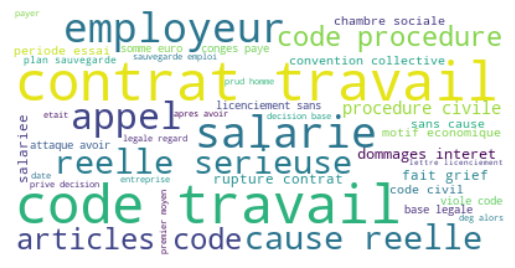

In [43]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()